# Machine Learning 5 - Clustering


In this example we will use the dataset on socioeconomic indicators from multiple countries to find groups or classifications based on unsupervised algorithms.

**Problem**

We have socioeconomic data from different countries such as mortality rate, inflation level, investment in health services, GDP, and exports. The objective is to categorize countries according to their indicators.

https://www.kaggle.com/datasets/rohan0301/unsupervised-learning-on-country-data

**Libraries**

In [ ]:
!pip install scikit-learn
!pip install skompiler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for skompiler: filename=SKompiler-0.7-py3-none-any.whl size=54310 sha256=de1f06a34e5c27bf880491313cb9f595acdc5c483b5cecbdb24e36ff32985671
  Stored in directory: /root/.cache/pip/wheels/c0/22/3d/bd8fd4c6cd205cf122a0974be908681472a6f44abd6b880614
Successfully built skompiler


In [ ]:
# data analytics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# machine learning (scikit-learn)
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import preprocessing
from sklearn.datasets import make_blobs,make_moons
from sklearn.metrics import silhouette_samples, silhouette_score

# miscellaneous
import os
import missingno as msno
import warnings
from tqdm import tqdm
warnings.simplefilter("ignore")

In [ ]:
filepath = 'Country-data.csv'

if os.path.exists(filepath):
  df = pd.read_csv(filepath)
  print('Dataset cargado correctamente')

Dataset cargado correctamente


## 1. Analysis of data

**Preliminary exploration**

We begin with a preliminary exploration of the data to understand the type of information we will be dealing with.

In [ ]:
df.head(5)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [ ]:
df.tail(5)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310
166,Zambia,83.1,37.0,5.89,30.9,3280,14.00,52.0,5.40,1460


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [ ]:
print('Total de columnas: {} | Total de filas: {}'.format(df.shape[1], df.shape[0]))

Total de columnas: 10 | Total de filas: 167


**Data Cleaning**

We analyze if we have to perform a preliminary data cleaning, we first identify if we have columns with nulls.

In [ ]:
cnt = 0
for col in df.columns:
  if df[col].isnull().values.any():
    print({'Columns with nulls' : col, 'Percentage of nulls' : round(df[col].isnull().sum()/df.shape[0]*100, 4)})
    cnt += 1

print('\nTotal columns with null data: {}'.format(cnt))


Total de columnas con datos nulos: 0


<Axes: >

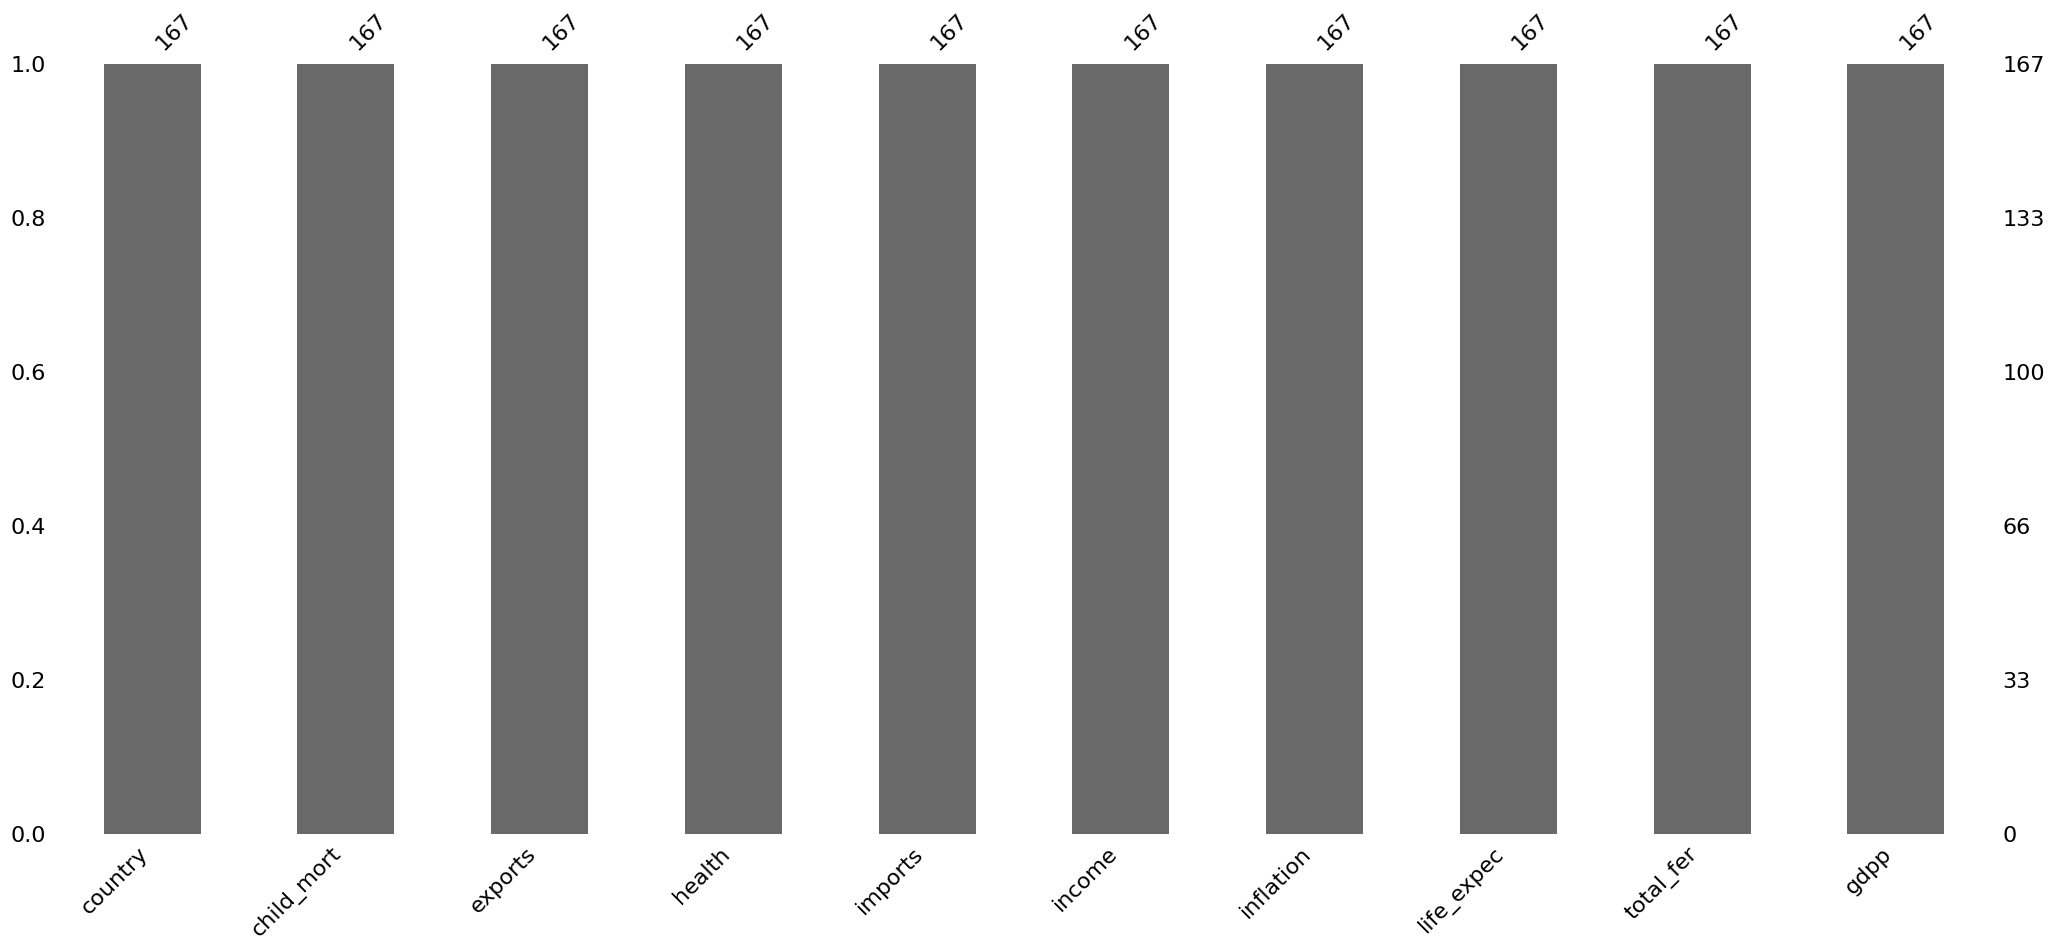

In [ ]:
msno.bar(df)

Podemos ver que este dataset no contiene nulos, así que no es necesario realizar ningún tipo de imputación.


**Outliers**

We proceed to review the distribution of extreme data (outliers). Since we will be performing unsupervised learning, it is generally not necessary to eliminate outliers unless the problem itself specifies it. However, it is interesting to carry out a visualization to help in subsequent explanations about the behavior of the groupings that we make.

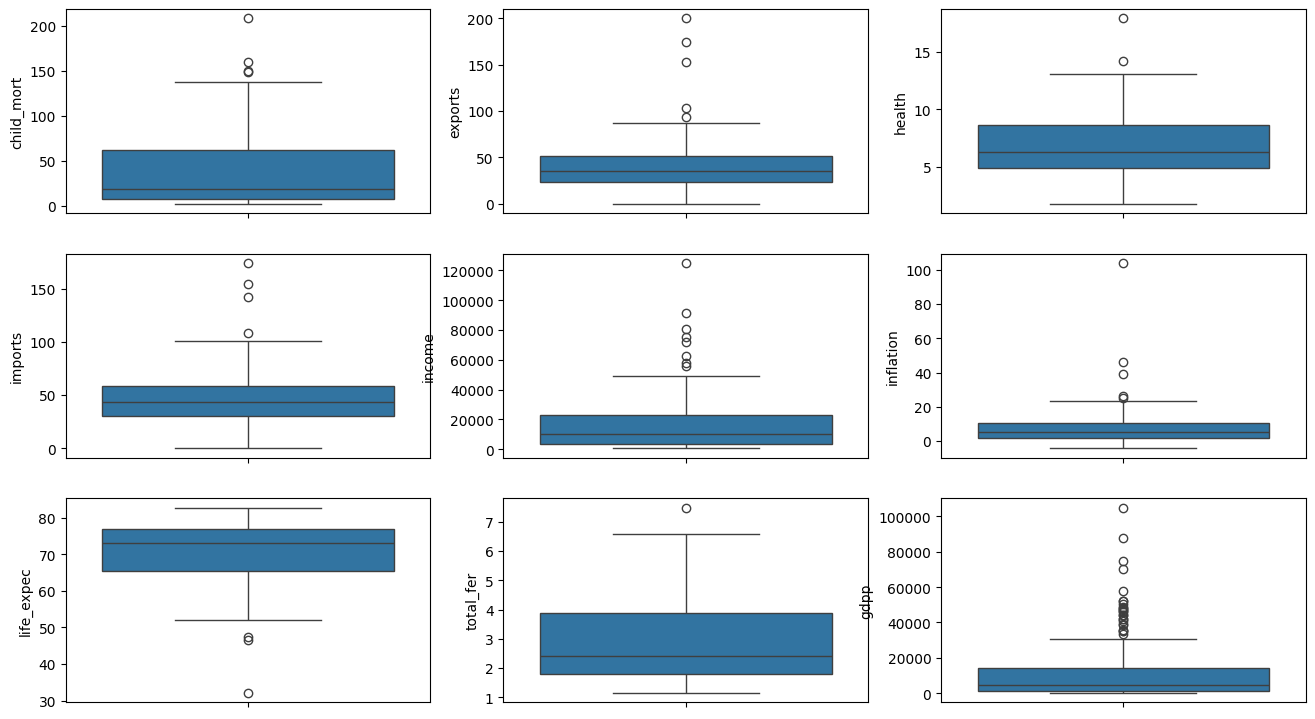

In [ ]:
plt.figure(figsize=(16,9))

# plot boxplots by groups
for i, col in enumerate(df.columns.drop('country').tolist()):
  plt.subplot(3,3,i+1)
  sns.boxplot(df[col])
  plt.xlabel('')
  plt.ylabel(col)

**Data distribution**

Since we will perform clustering, it is important to perform an analysis of the data distribution.

In [ ]:
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


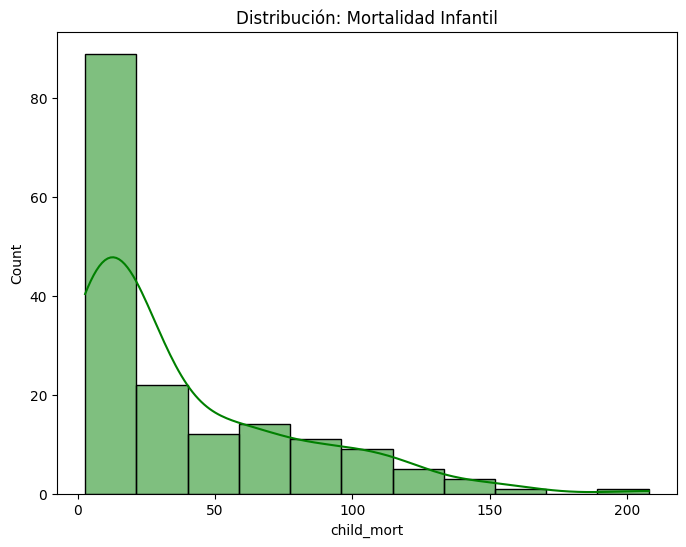

In [ ]:
plt.figure(figsize=(8,6))
sns.histplot(data=df, x="child_mort", color='green', kde=True)
plt.title("Distribution: Child Mortality")
plt.show()

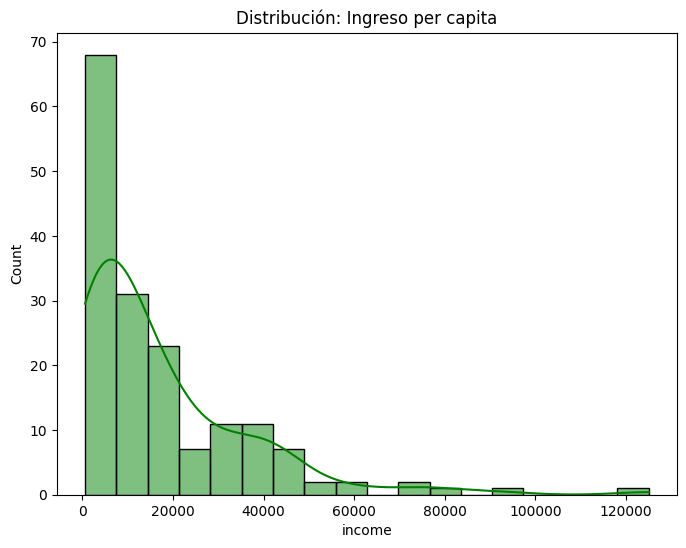

In [ ]:
plt.figure(figsize=(8,6))
sns.histplot(data=df, x="income", color='green', kde=True)
plt.title("Distribution: Per capita income")
plt.show()

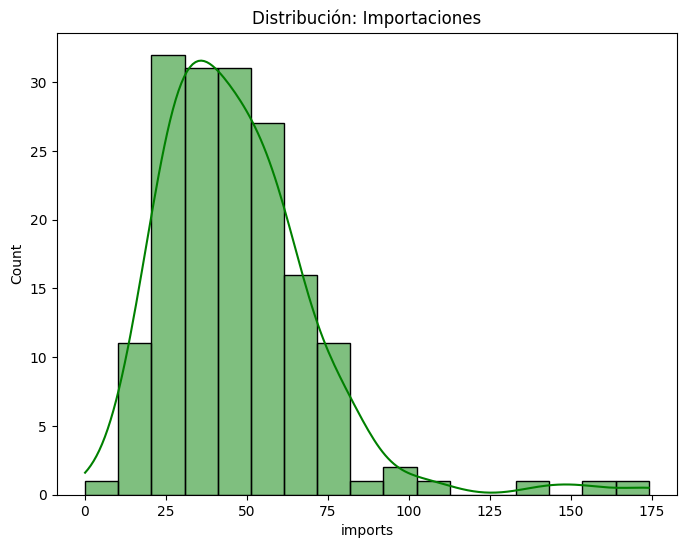

In [ ]:
plt.figure(figsize=(8,6))
sns.histplot(data=df, x="imports", color='green', kde=True)
plt.title("Distribution: Imports")
plt.show()

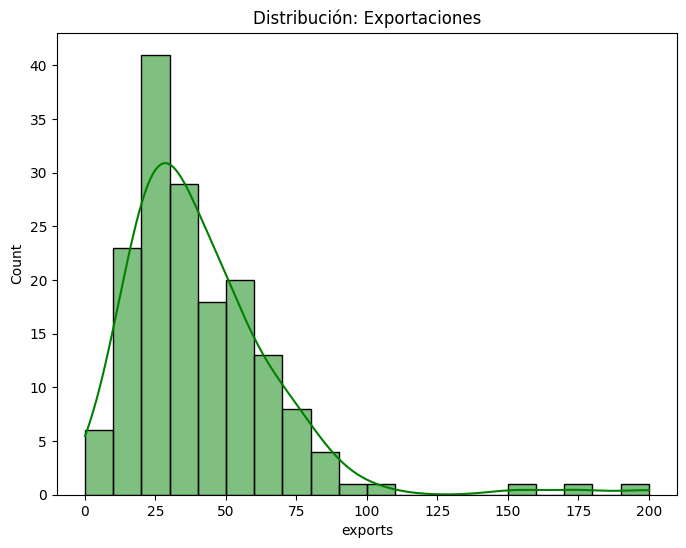

In [ ]:
plt.figure(figsize=(8,6))
sns.histplot(data=df, x="exports", color='green', kde=True)
plt.title("Distribution: Exports")
plt.show()

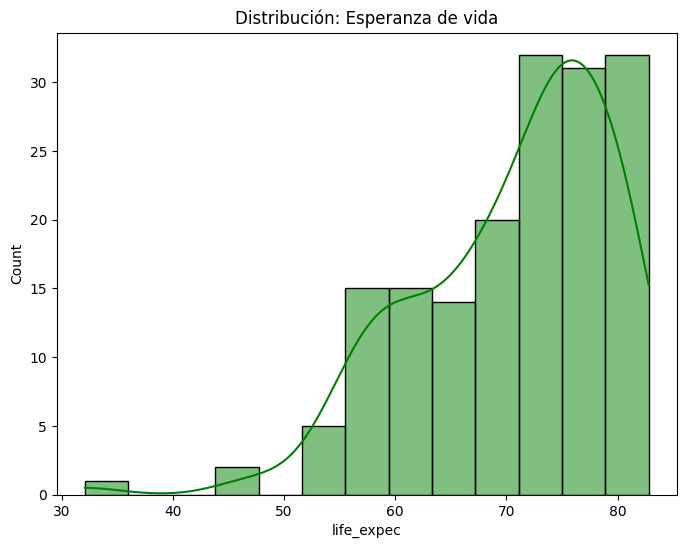

In [ ]:
plt.figure(figsize=(8,6))
sns.histplot(data=df, x="life_expec", color='green', kde=True)
plt.title("Distribution: Life Expectancy")
plt.show()

**Data correlation**

To understand if there are potential data groupings, we can study their correlations and understand the dependencies between variables.

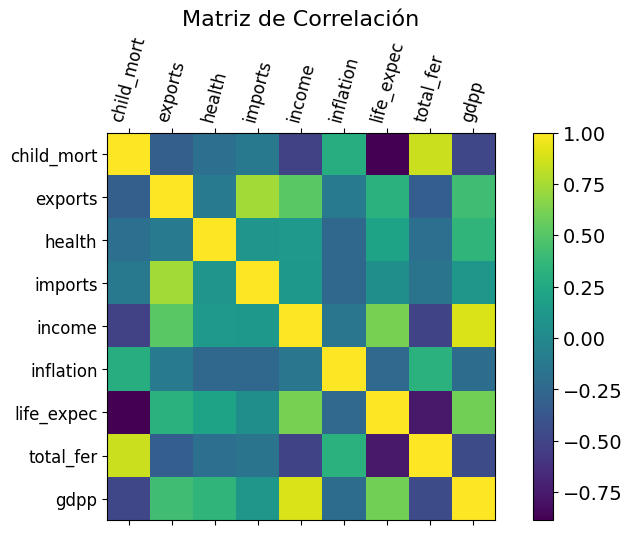

In [ ]:
# calculate correlation matrix
corr_matrix = df.drop('country', axis=1).corr('pearson')

# plot correlation matrix
fig = plt.figure(figsize=(10,5))
plt.matshow(corr_matrix, fignum=fig)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=12, rotation=75)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

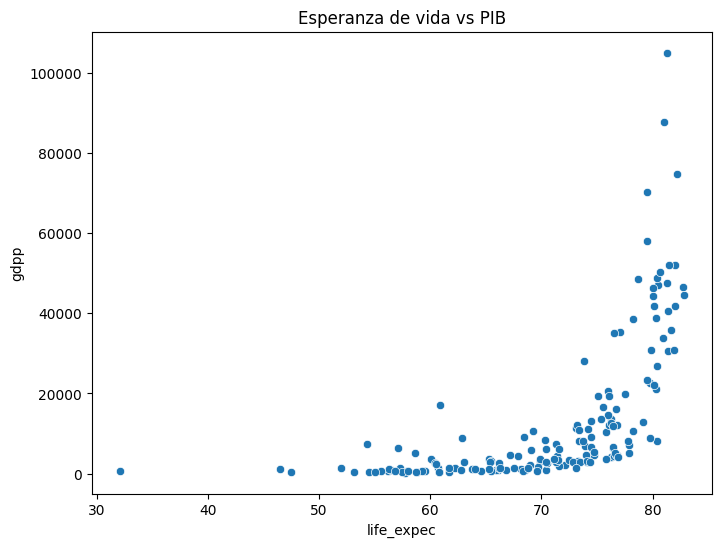

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="life_expec", y='gdpp')
plt.title("Life Expectancy vs GDPP")
plt.show()

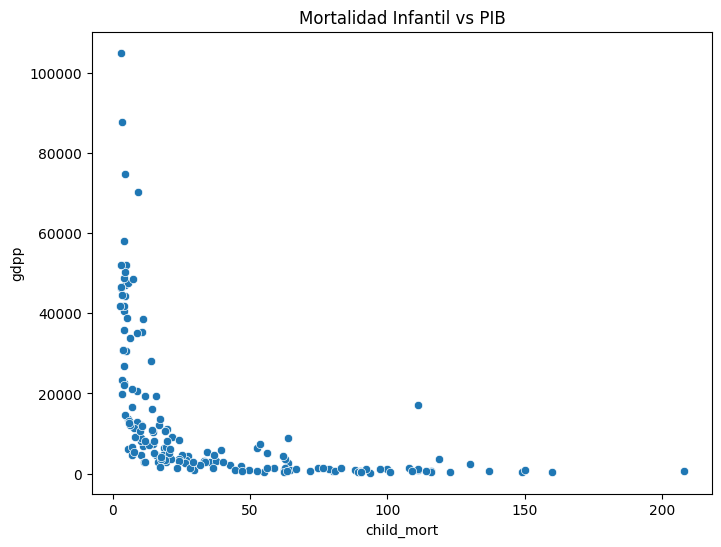

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="child_mort", y='gdpp')
plt.title("Child Mortality vs GDPP")
plt.show()

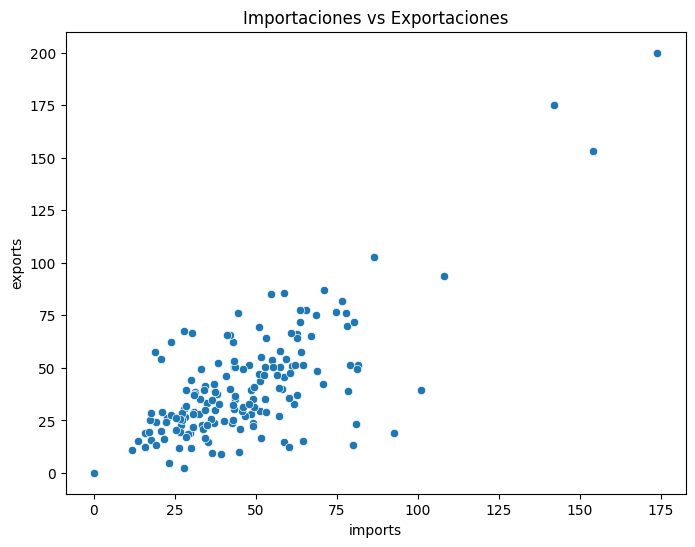

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="imports", y='exports')
plt.title("Imports vs Exports")
plt.show()

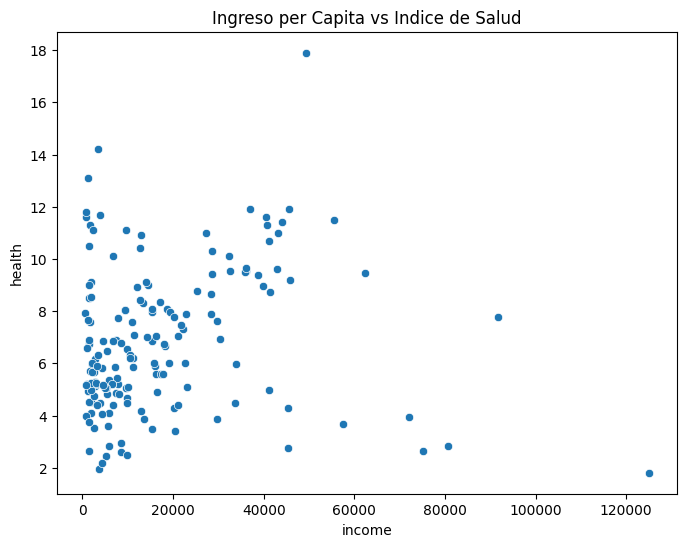

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="income", y='health')
plt.title("Per Capita Income vs Health Index")
plt.show()

## 2. Modeling

**Processing for model**

The only type of categorical data we have are country names. However, since we will perform data clustering without taking into account the names, it is not necessary to encode them, and we will only use the names later to facilitate the analysis of results.

In [ ]:
df.dtypes

country        object
child_mort    float64
exports       float64
health        float64
imports       float64
income          int64
inflation     float64
life_expec    float64
total_fer     float64
gdpp            int64
dtype: object

In [ ]:
data = df[df.columns.drop('country')]
data.head(5)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


Vemos que cada columna se encuentra en diferente escala, por lo que es necesario renormalizar los datos.

In [ ]:
# define scaler
scaler = StandardScaler()

# applier scaler to dataset
data_scaled = scaler.fit_transform(data)

data_scaled

array([[ 1.29153238, -1.13827979,  0.27908825, ..., -1.61909203,
         1.90288227, -0.67917961],
       [-0.5389489 , -0.47965843, -0.09701618, ...,  0.64786643,
        -0.85997281, -0.48562324],
       [-0.27283273, -0.09912164, -0.96607302, ...,  0.67042323,
        -0.0384044 , -0.46537561],
       ...,
       [-0.37231541,  1.13030491,  0.0088773 , ...,  0.28695762,
        -0.66120626, -0.63775406],
       [ 0.44841668, -0.40647827, -0.59727159, ..., -0.34463279,
         1.14094382, -0.63775406],
       [ 1.11495062, -0.15034774, -0.33801514, ..., -2.09278484,
         1.6246091 , -0.62954556]])

In [ ]:
pd.DataFrame(columns=data.columns, data=data_scaled).head(5)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882,-0.679180
1,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973,-0.485623
2,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404,-0.465376
3,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151,-0.516268
4,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946,-0.041817


## Clustering: K-Means

One of the best-known models for clustering is K-means, which allows data to be grouped into K different groups (or clusters) based on their distances between them in an n-dimensional space, where n is the number of variables that make up the dataset. . There are different distances that are considered to make the grouping:

* Hamming distance: distance between two binary vectors.

* Euclidean Distance: square of the distance between two real vectors.

* Manhattan distance: absolute distance between two real vectors.

* Minkowsky distance: distance between two points in an n-dimensional space.

In [ ]:
# initialize the model
kmeans_mod = KMeans(n_clusters=2) # default: Euclidean distance

In [ ]:
# adjust the model
kmeans_mod.fit(data_scaled)

KMeans(n_clusters=2)

In [ ]:
# get the predictions (the group ids)
label_preds = kmeans_mod.predict(data_scaled)
label_preds

array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1], dtype=int32)

Podemos agregar las predicciones al dataset original para visualizar los países que pertenencen a cada grupo.

In [ ]:
# create results dataframe
df['Grupo'] = label_preds
df.head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Grupo
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.440,56.2,5.82,553,1
1,Albania,16.6,28.0,6.55,48.6,9930,4.490,76.3,1.65,4090,0
2,Algeria,27.3,38.4,4.17,31.4,12900,16.100,76.5,2.89,4460,0
3,Angola,119.0,62.3,2.85,42.9,5900,22.400,60.1,6.16,3530,1
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.440,76.8,2.13,12200,0
5,Argentina,14.5,18.9,8.10,16.0,18700,20.900,75.8,2.37,10300,0
6,Armenia,18.1,20.8,4.40,45.3,6700,7.770,73.3,1.69,3220,0
7,Australia,4.8,19.8,8.73,20.9,41400,1.160,82.0,1.93,51900,0
8,Austria,4.3,51.3,11.00,47.8,43200,0.873,80.5,1.44,46900,0
9,Azerbaijan,39.2,54.3,5.88,20.7,16000,13.800,69.1,1.92,5840,0


We can study the correlations of the new groups.

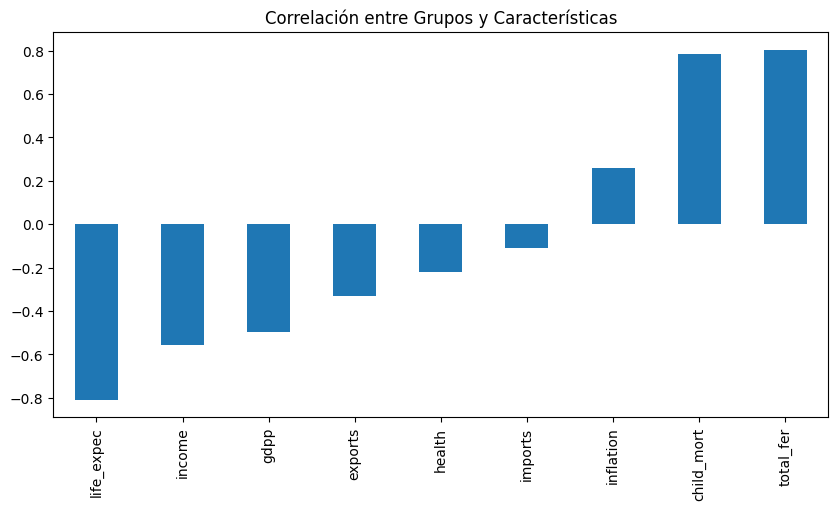

In [ ]:
plt.figure(figsize=(10,5))
df.drop('country', axis=1).corr()["Grupo"].iloc[:-1].sort_values().plot(kind="bar")
plt.title("Correlation between Groups and Features")
plt.show()

We can compare how the distributions in each group compare.

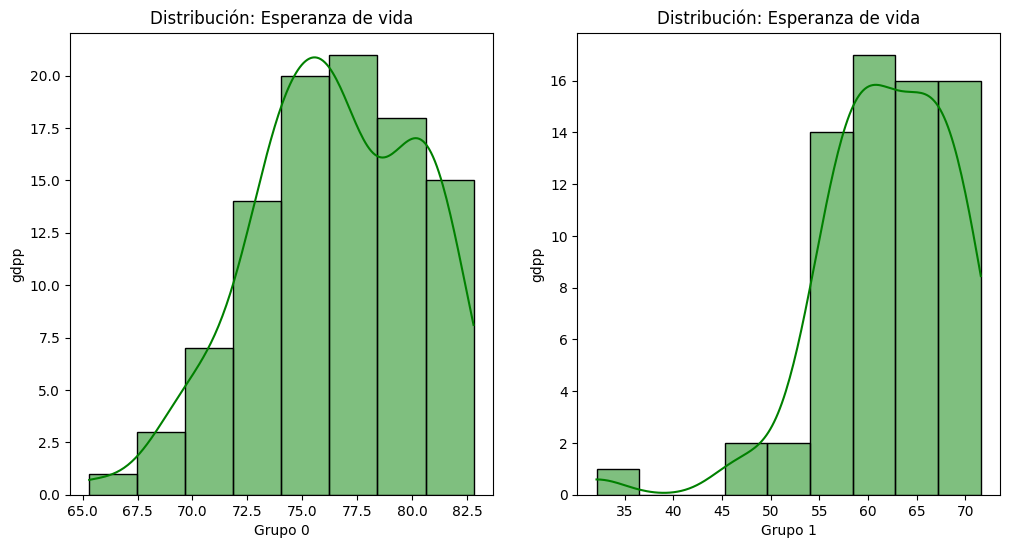

In [ ]:
plt.figure(figsize=(12,6))

# plot distributions for features by group
for i in range(0,2):
  plt.subplot(1,2,i+1)
  sns.histplot(data=df[df['Grupo'] == i], x="life_expec", color='green', kde=True)
  plt.title("Distribution: Life Expectancy")
  plt.xlabel('Group {}'.format(i))
  plt.ylabel(col)

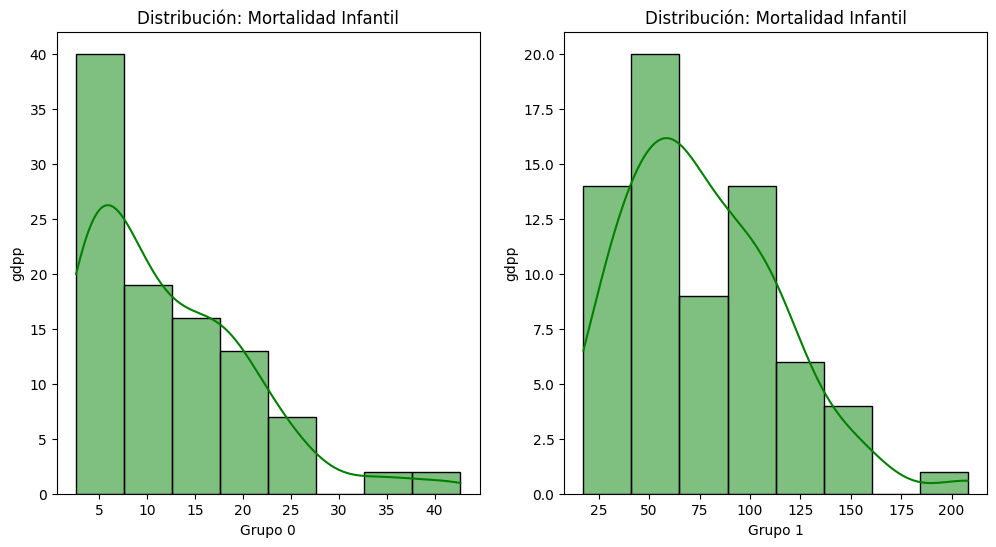

In [ ]:
plt.figure(figsize=(12,6))

# plot distributions for features by group
for i in range(0,2):
  plt.subplot(1,2,i+1)
  sns.histplot(data=df[df['Grupo'] == i], x="child_mort", color='green', kde=True)
  plt.title("Distribution: Child Mortality")
  plt.xlabel('Group {}'.format(i))
  plt.ylabel(col)

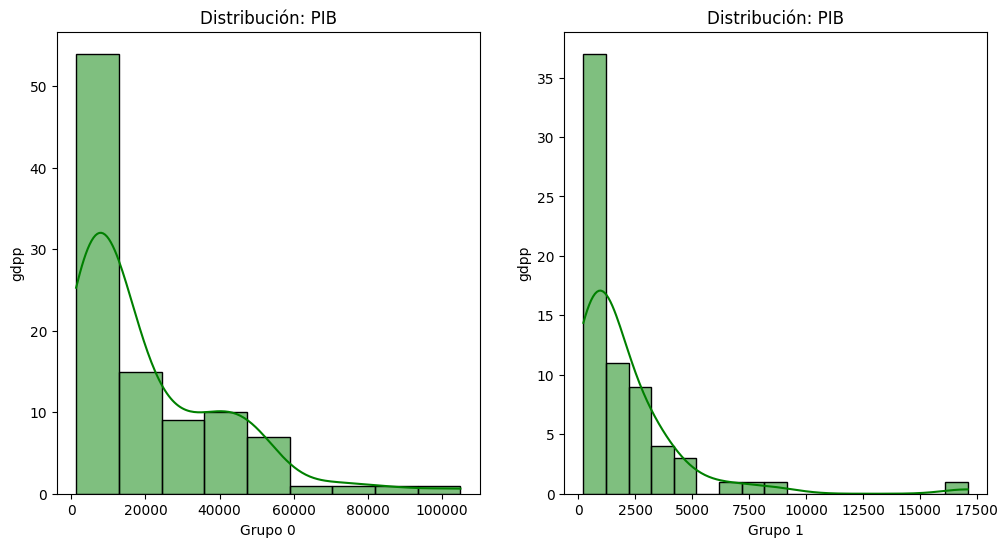

In [ ]:
plt.figure(figsize=(12,6))

# plot distributions for features by group
for i in range(0,2):
  plt.subplot(1,2,i+1)
  sns.histplot(data=df[df['Grupo'] == i], x="gdpp", color='green', kde=True)
  plt.title("Distribution: GDPP")
  plt.xlabel('Group {}'.format(i))
  plt.ylabel(col)

However, we can increase the number of clusters we can form.

In [ ]:
# initialize the model with 4 clusters
kmeans_mod = KMeans(n_clusters=4)

# train model
kmeans_mod.fit(data_scaled)

# get predictions
label_preds = kmeans_mod.predict(data_scaled)

In [ ]:
# create results dataframe
df['Grupo'] = label_preds
df.head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Grupo
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.440,56.2,5.82,553,1
1,Albania,16.6,28.0,6.55,48.6,9930,4.490,76.3,1.65,4090,2
2,Algeria,27.3,38.4,4.17,31.4,12900,16.100,76.5,2.89,4460,2
3,Angola,119.0,62.3,2.85,42.9,5900,22.400,60.1,6.16,3530,1
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.440,76.8,2.13,12200,2
5,Argentina,14.5,18.9,8.10,16.0,18700,20.900,75.8,2.37,10300,2
6,Armenia,18.1,20.8,4.40,45.3,6700,7.770,73.3,1.69,3220,2
7,Australia,4.8,19.8,8.73,20.9,41400,1.160,82.0,1.93,51900,0
8,Austria,4.3,51.3,11.00,47.8,43200,0.873,80.5,1.44,46900,0
9,Azerbaijan,39.2,54.3,5.88,20.7,16000,13.800,69.1,1.92,5840,2


We again reviewed the correlations and distributions of some variables of these new groups.

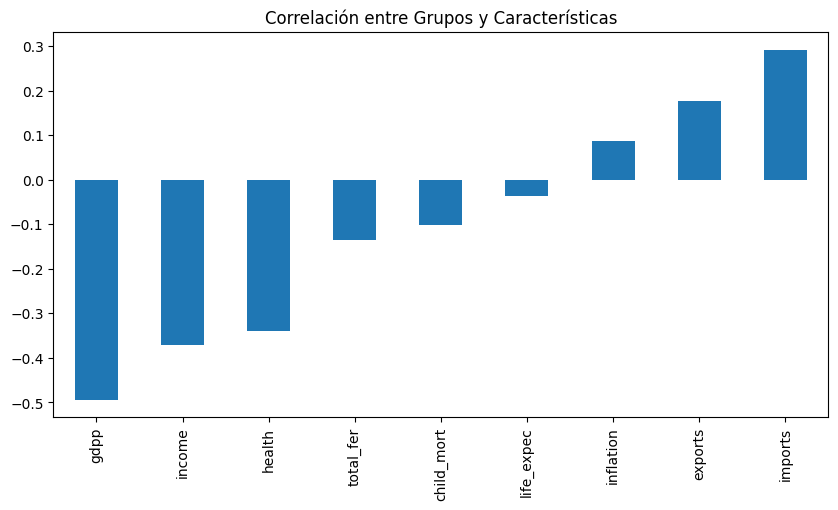

In [ ]:
plt.figure(figsize=(10,5))
df.drop('country', axis=1).corr()["Grupo"].iloc[:-1].sort_values().plot(kind="bar")
plt.title("Correlation between Groups and Features")
plt.show()

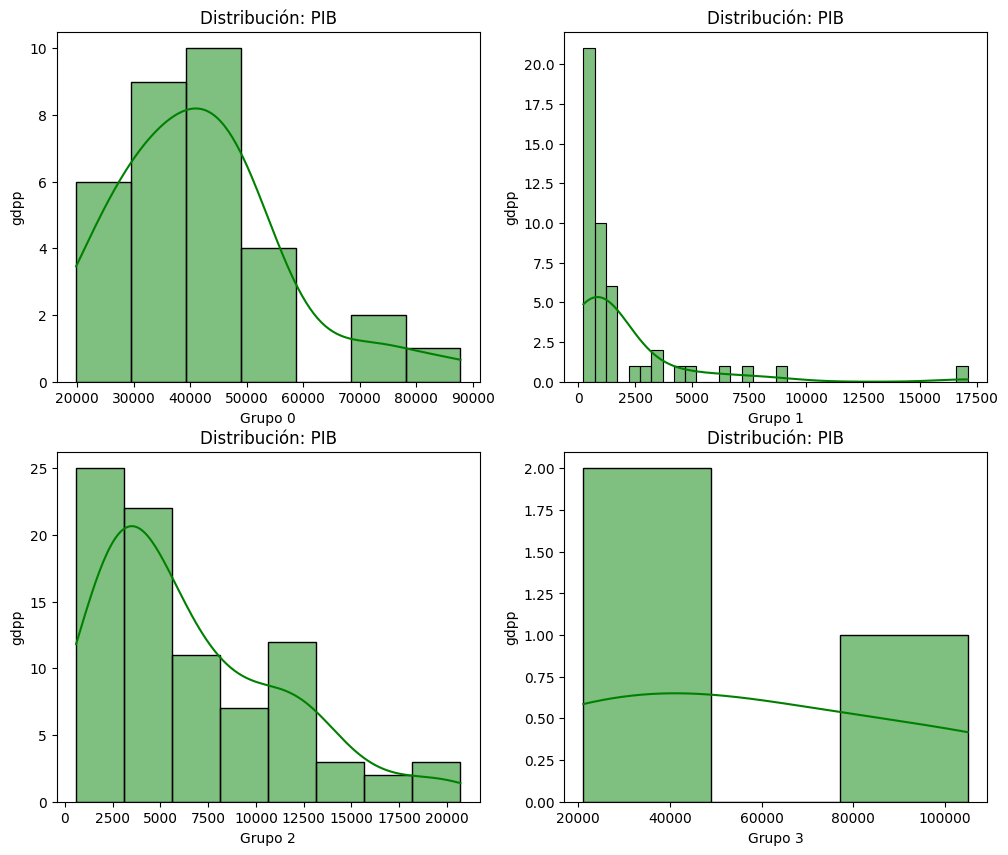

In [ ]:
plt.figure(figsize=(12,10))

# plot distributions for features by group
for i in range(0,4):
  plt.subplot(2,2,i+1)
  sns.histplot(data=df[df['Grupo'] == i], x="gdpp", color='green', kde=True)
  plt.title("Distribution: GDPP")
  plt.xlabel('Group {}'.format(i))
  plt.ylabel(col)

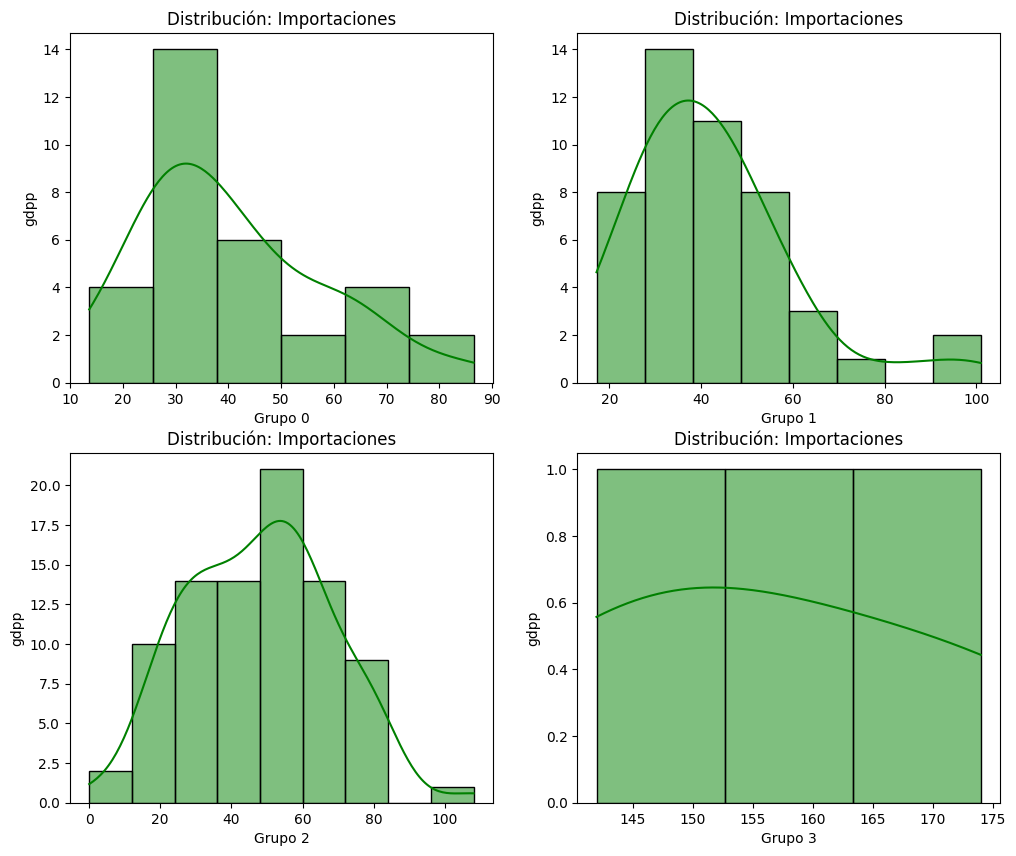

In [ ]:
plt.figure(figsize=(12,10))

# plot distributions for features by group
for i in range(0,4):
  plt.subplot(2,2,i+1)
  sns.histplot(data=df[df['Grupo'] == i], x="imports", color='green', kde=True)
  plt.title("Distribution: Imports")
  plt.xlabel('Group {}'.format(i))
  plt.ylabel(col)

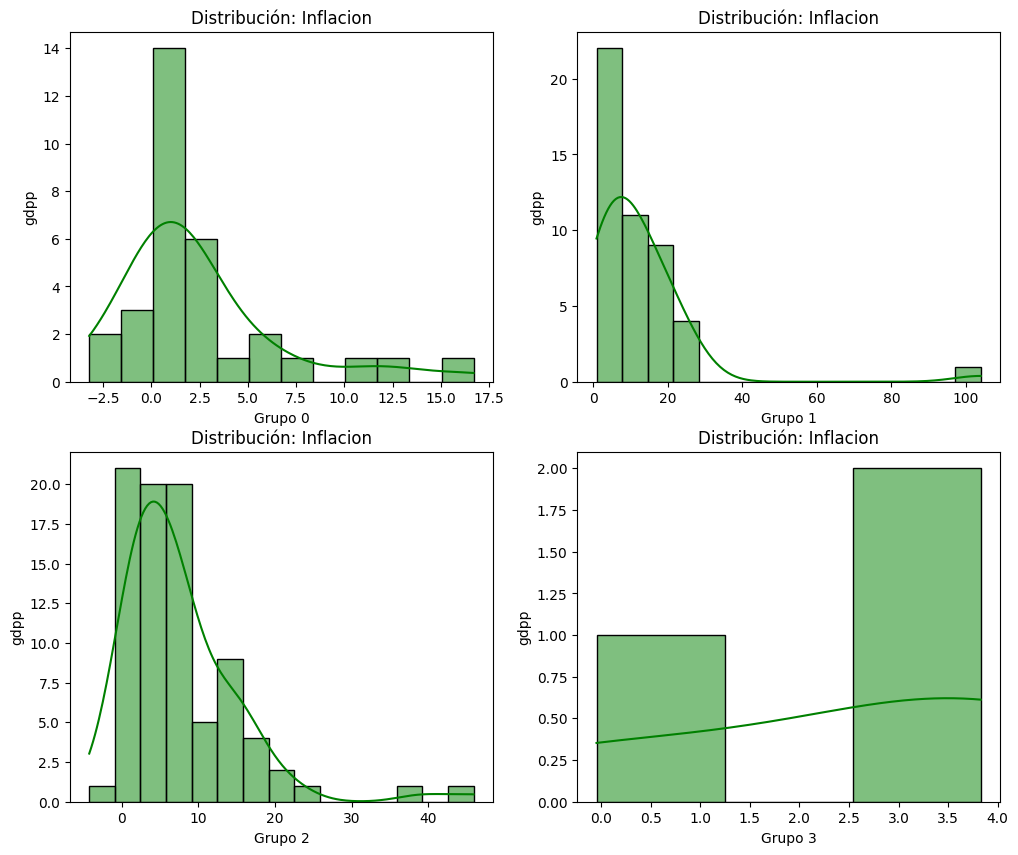

In [ ]:
plt.figure(figsize=(12,10))

# graficar boxplots en grupos
# enumerate: 1er valor es el índice (entero), 2do valor es el valor de la lista (str/num/etc.)
for i in range(0,4):
  plt.subplot(2,2,i+1)
  sns.histplot(data=df[df['Grupo'] == i], x="inflation", color='green', kde=True)
  plt.title("Distribution: Inflation")
  plt.xlabel('Group {}'.format(i))
  plt.ylabel(col)

**K-Means: Elbow Curve Method**

Depending on the objectives of the study, we may have an expected number of clusters that we wish to obtain from the data. However, when we do not have in-depth knowledge of the data or we simply want to find the most optimal grouping, there are ways to find the optimal number of clusters that should be formed for a dataset. In other words, we want to minimize the similarity between points within each cluster and maximize the difference between clusters.

One of the most common methods for graphical inspection is the elbow curve method, where the optimal number of clusters is where the graph drops suddenly forming an "elbow."

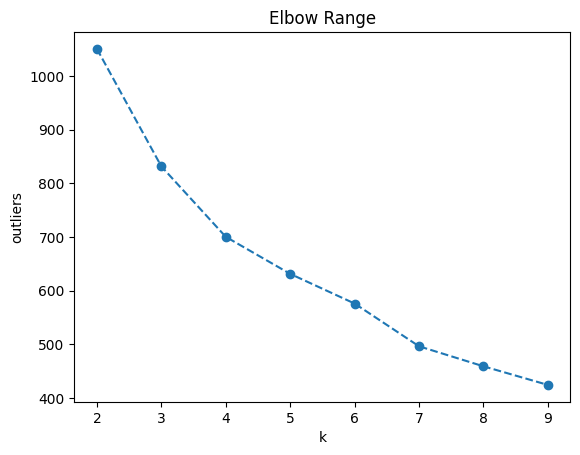

In [ ]:
# perform adjustment for different values ​​of K
ssd = []
for k in range(2, 10):
  model = KMeans(n_clusters=k)
  model.fit(data_scaled)
  ssd.append(model.inertia_)

# graph elbow range
plt.plot(range(2, 10),ssd,"o--")
plt.ylabel('outliers')
plt.xlabel('k')
plt.title("Elbow Range")
plt.show()

It seems that k=3 or k=4 is the optimal value of clusters that we should obtain for this dataset.

**KMeans: Silhouette Method**

Another way to obtain the optimal value of K, especially when there is ambiguity in the elbow method, is by studying the separation distance between the resulting clusters. This allows us to identify how similar the elements belonging to the same cluster are and how far apart the clusters are quantitatively.

Para n_clusters=2, silhouette_score=0.28735668921406704
Para n_clusters=3, silhouette_score=0.28329575683463126
Para n_clusters=4, silhouette_score=0.301375962376881
Para n_clusters=5, silhouette_score=0.25445574825449885
Para n_clusters=6, silhouette_score=0.22799367131601095


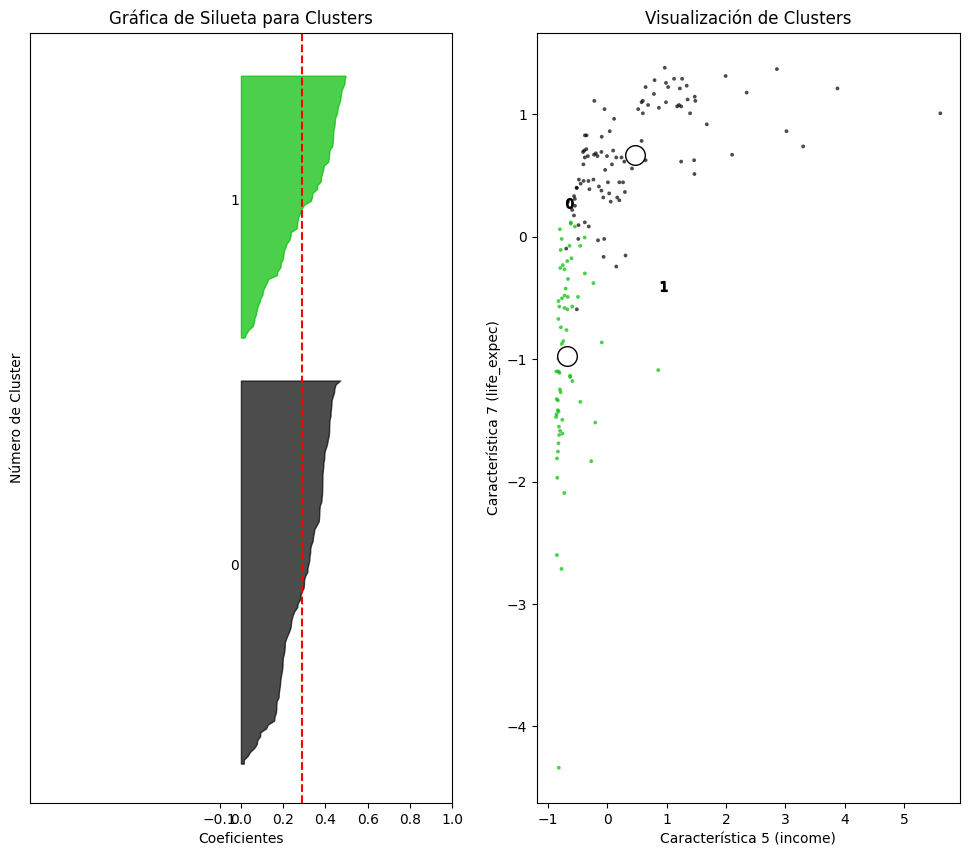

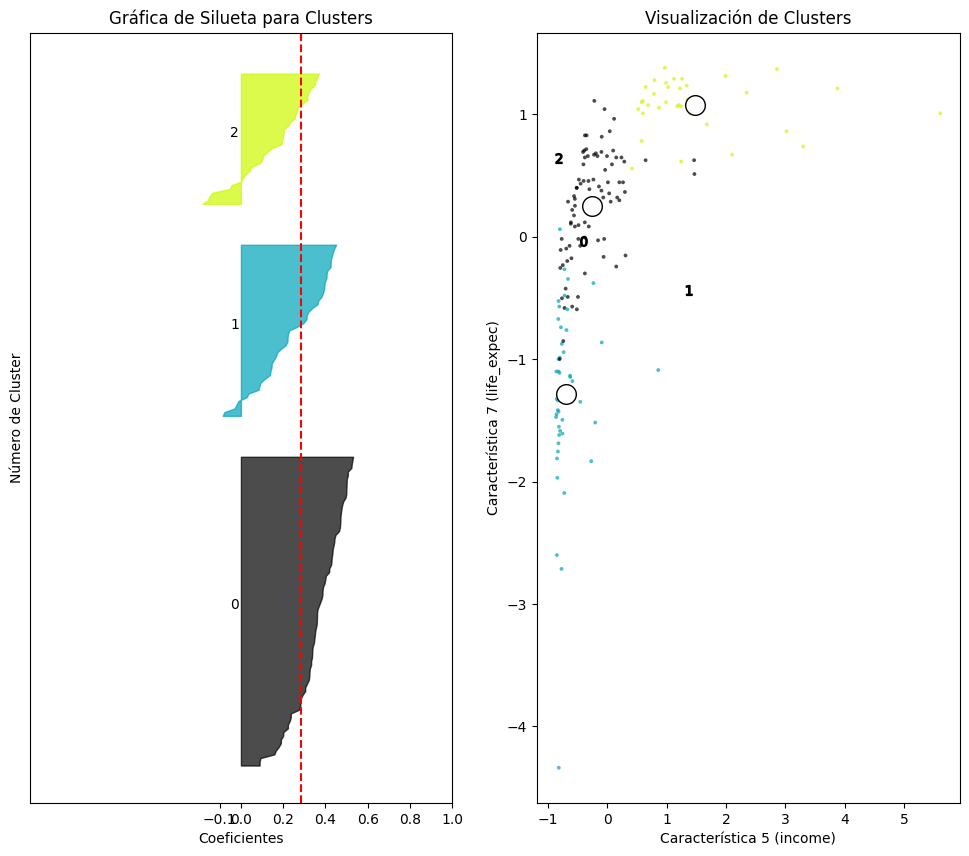

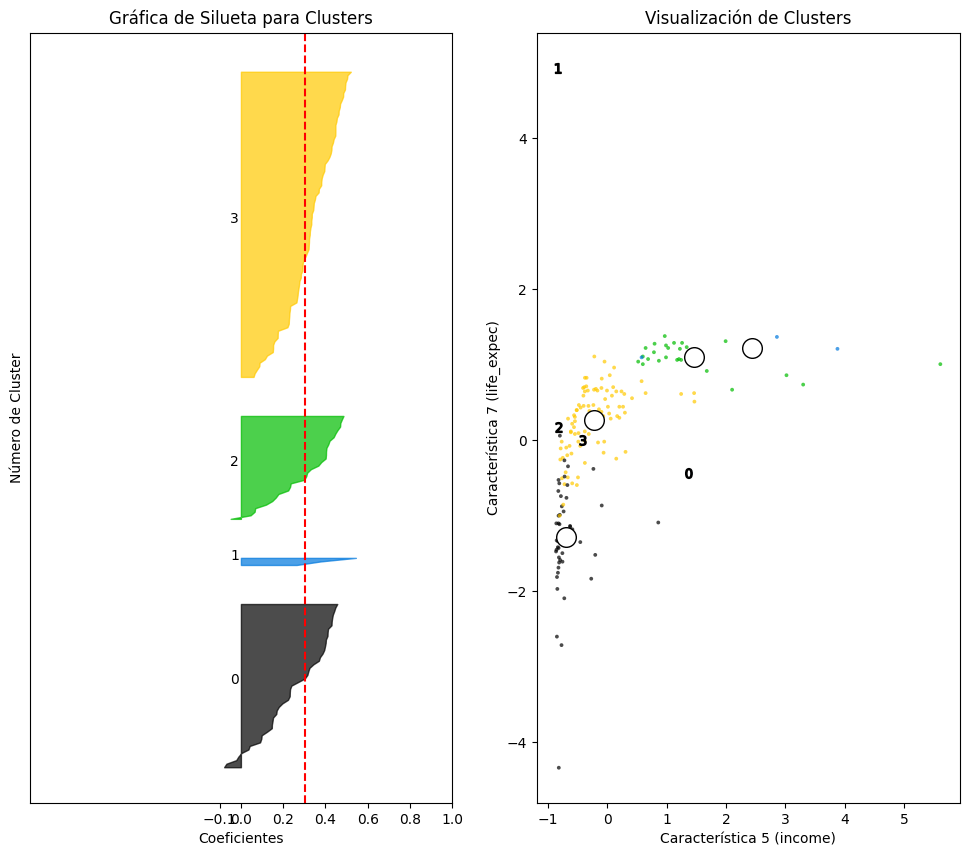

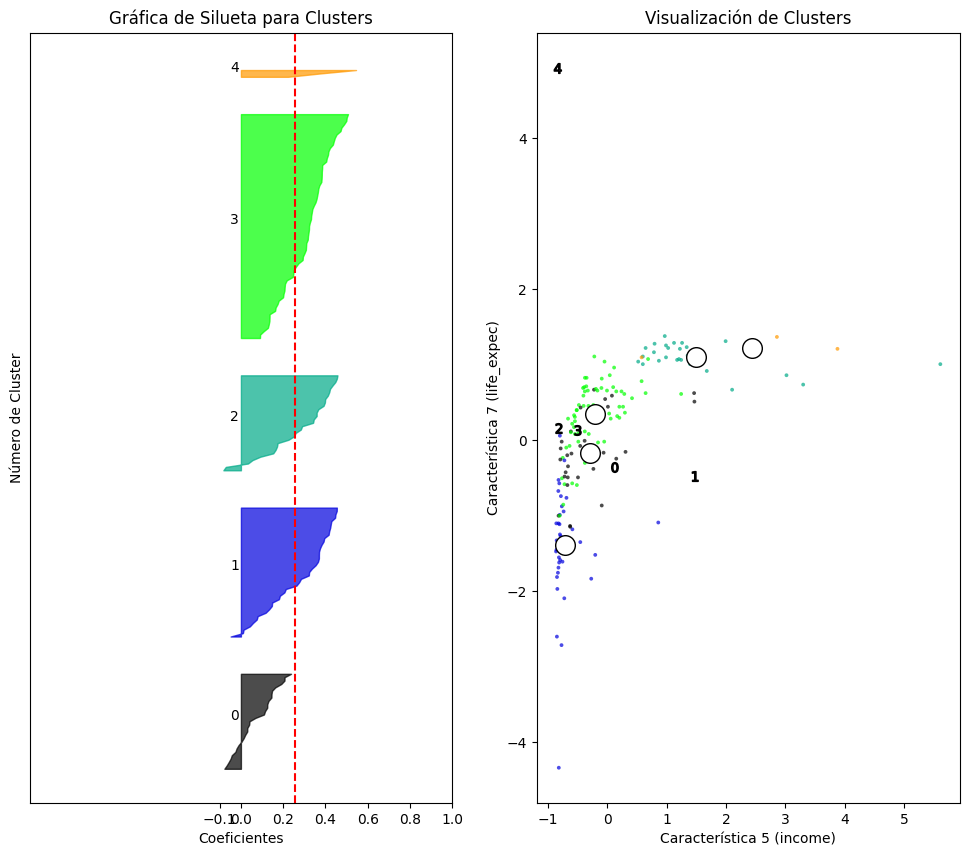

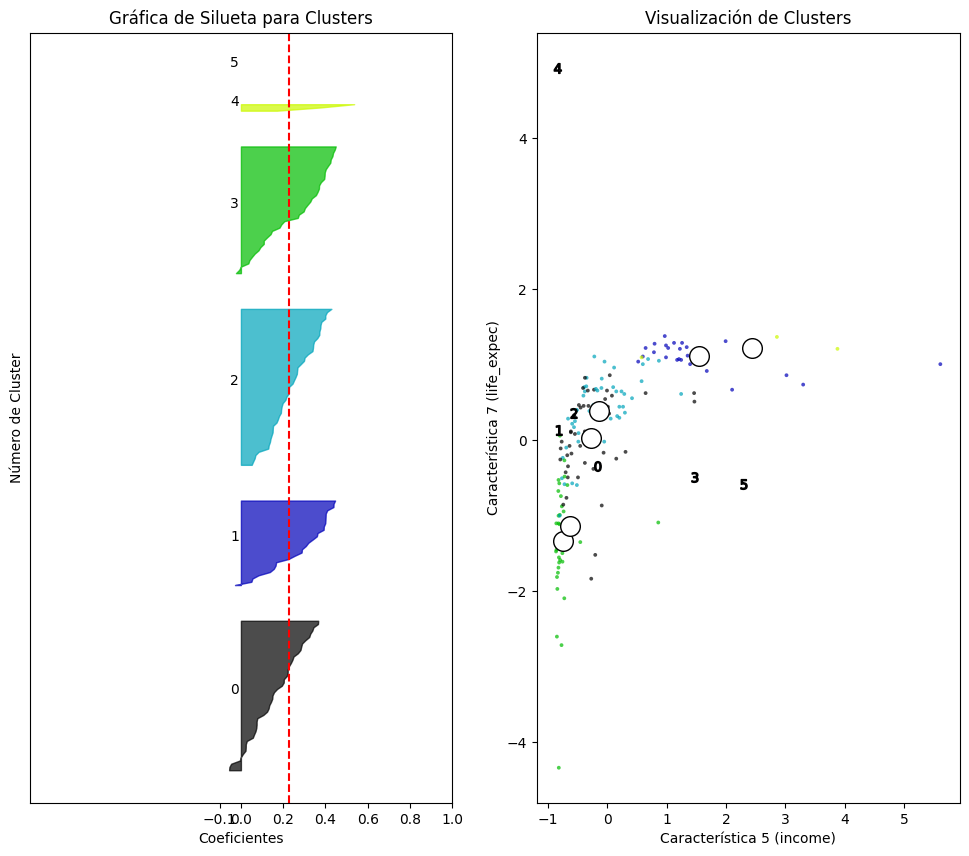

In [ ]:
a, b = 4, 6

for n_clusters in range(2, 7):

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(12, 10)

    ax1.set_xlim([-1, 1]) # the silhouette has a range between -1 and +1
    ax1.set_ylim([0, len(data_scaled) + (n_clusters + 1) * 10])

    # model fit
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(data_scaled)

    # we calculate the value of the silhouette
    silhouette_avg = silhouette_score(data_scaled, cluster_labels)
    print("For n_clusters={}, silhouette_score={}".format(n_clusters, silhouette_avg))

    # left graph: calculate the values ​​for each sample
    sample_silhouette_values = silhouette_samples(data_scaled, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),0,ith_cluster_silhouette_values,facecolor=color,edgecolor=color,alpha=0.7,)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title("Silhoutte for Clusters Plot")
    ax1.set_xlabel("Coefficients")
    ax1.set_ylabel("Number of Cluster")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # graph right: visualize the clusters as points
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(data_scaled[:, a], data_scaled[:, b], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")

    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, a], centers[:, b],marker="o",c="white",alpha=1,s=200,edgecolor="k",)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("Visualization of Clusters")
    ax2.set_xlabel("Feature {} ({})".format(a+1, df.columns[a+1]))
    ax2.set_ylabel("Feature {} ({})".format(b+1, df.columns[b+1]))

plt.show()

The maximum silhouette value is obtained for k=4, therefore the optimal cluster value for this dataset is 4.

## Clustering: Hierarchical Clustering

One of the disadvantages of K-Means is the need to specify the number of clusters. Therefore, we can opt for hierarchical clustering, which automatically selects the best approach for grouping features depending on the different correlations between data.

There are two types:

* Agglomerative clustering: each data is treated as a singleton and is successively agglomerated into clusters until all have been combined into a single cluster with all the data. (we used this in the exercise)

* Divisive clustering: it starts with a cluster with all the data and is successively divided into clusters recursively until all the data has been separated into singletons.

Let's first visualize the potential hierarchical correlations that exist in the original dataset using a cluster heatmap.

<Figure size 1000x600 with 0 Axes>

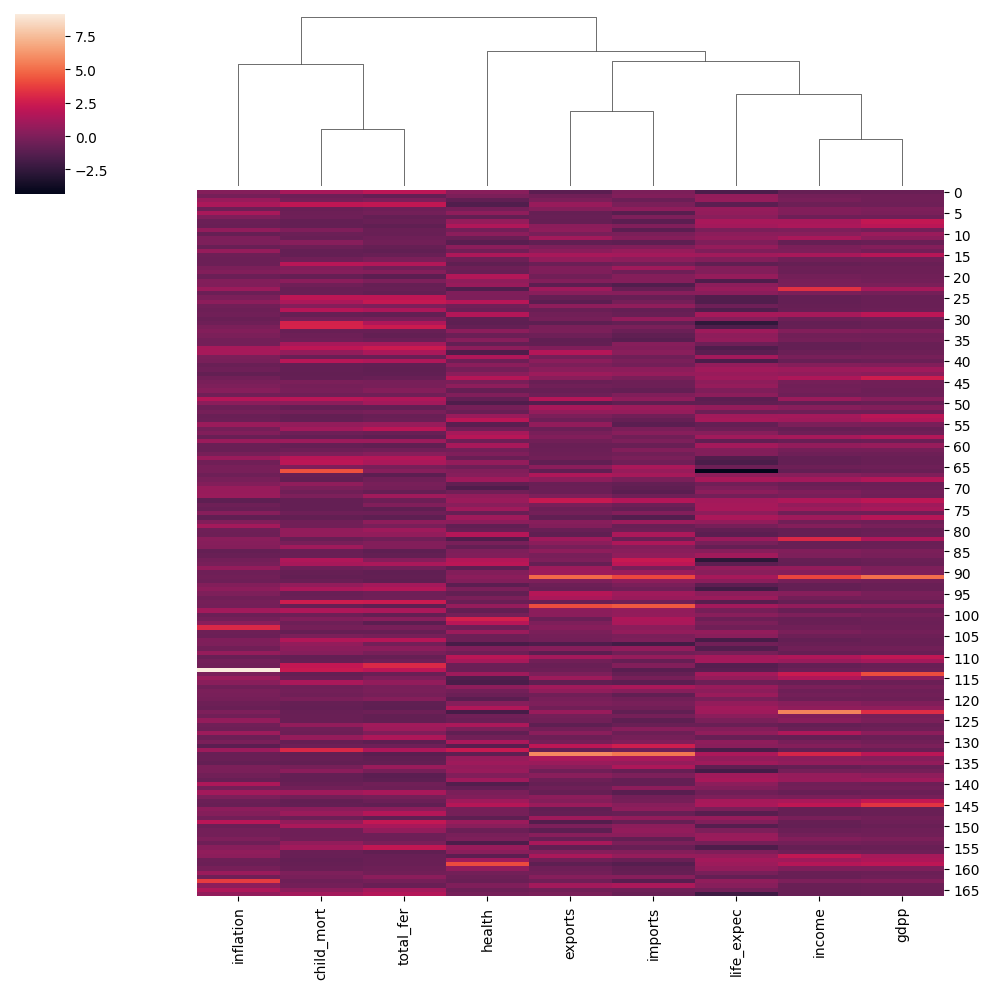

In [ ]:
plt.figure(figsize=(10,6))
sns.clustermap(pd.DataFrame(data_scaled, columns=data.columns), metric='euclidean', row_cluster=False)
plt.show()

Let's see what results we obtain by adjusting the hierarchical model.

In [ ]:
# initialize the model
hier_model = AgglomerativeClustering(n_clusters=4, affinity="euclidean")

In [ ]:
# train the model
labels_pred = hier_model.fit_predict(data_scaled)
labels_pred

array([2, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0,
       0, 1, 0, 2, 2, 0, 2, 1, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 2, 0, 1, 0, 1, 0, 0, 2, 2, 0,
       2, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 3, 0, 2, 2, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       1, 1, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 2, 0, 1, 2, 0, 0,
       2, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 0, 2, 0, 0, 0,
       0, 2, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2])

In [ ]:
# create results dataframe
df['Grupo'] = label_preds
df.head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Grupo
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.440,56.2,5.82,553,1
1,Albania,16.6,28.0,6.55,48.6,9930,4.490,76.3,1.65,4090,2
2,Algeria,27.3,38.4,4.17,31.4,12900,16.100,76.5,2.89,4460,2
3,Angola,119.0,62.3,2.85,42.9,5900,22.400,60.1,6.16,3530,1
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.440,76.8,2.13,12200,2
5,Argentina,14.5,18.9,8.10,16.0,18700,20.900,75.8,2.37,10300,2
6,Armenia,18.1,20.8,4.40,45.3,6700,7.770,73.3,1.69,3220,2
7,Australia,4.8,19.8,8.73,20.9,41400,1.160,82.0,1.93,51900,0
8,Austria,4.3,51.3,11.00,47.8,43200,0.873,80.5,1.44,46900,0
9,Azerbaijan,39.2,54.3,5.88,20.7,16000,13.800,69.1,1.92,5840,2


We can visualize what the correlations look like under this other approach.

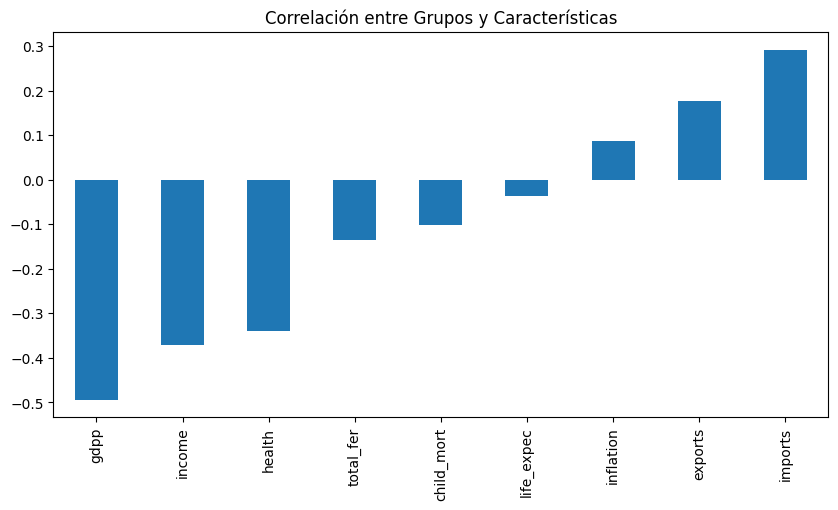

In [ ]:
plt.figure(figsize=(10,5))
df.drop('country', axis=1).corr()["Grupo"].iloc[:-1].sort_values().plot(kind="bar")
plt.title("Correlation between Groups and Features")
plt.show()

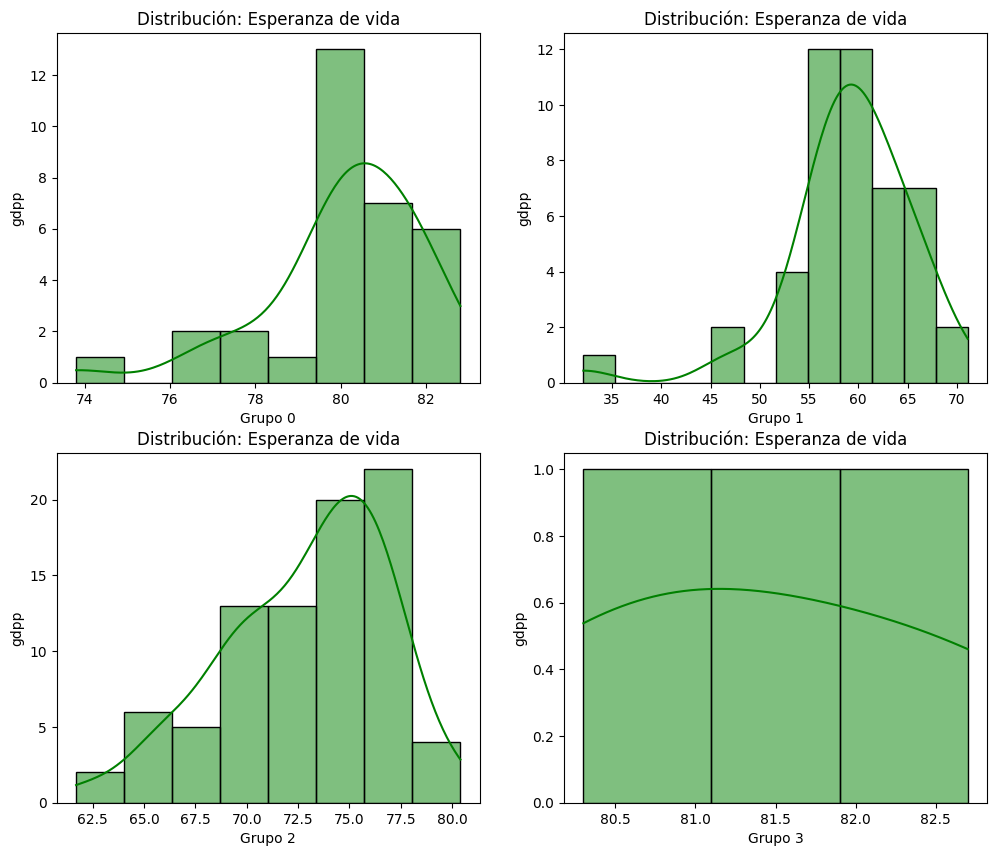

In [ ]:
plt.figure(figsize=(12,10))

# plot distributions for features by group
for i in range(0,4):
  plt.subplot(2,2,i+1)
  sns.histplot(data=df[df['Grupo'] == i], x="life_expec", color='green', kde=True)
  plt.title("Distribution: Life Expectancy")
  plt.xlabel('Group {}'.format(i))
  plt.ylabel(col)

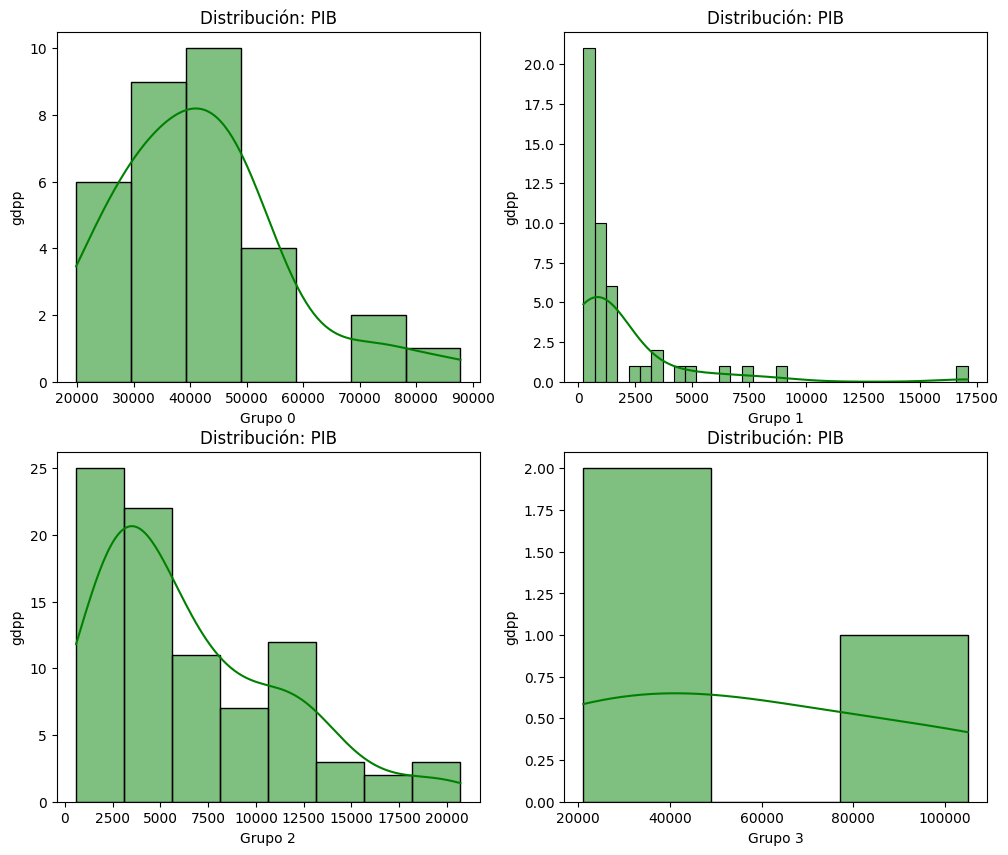

In [ ]:
plt.figure(figsize=(12,10))

# plot distributions for features by group
for i in range(0,4):
  plt.subplot(2,2,i+1)
  sns.histplot(data=df[df['Grupo'] == i], x="gdpp", color='green', kde=True)
  plt.title("Distribution: GDPP")
  plt.xlabel('Grupo {}'.format(i))
  plt.ylabel(col)

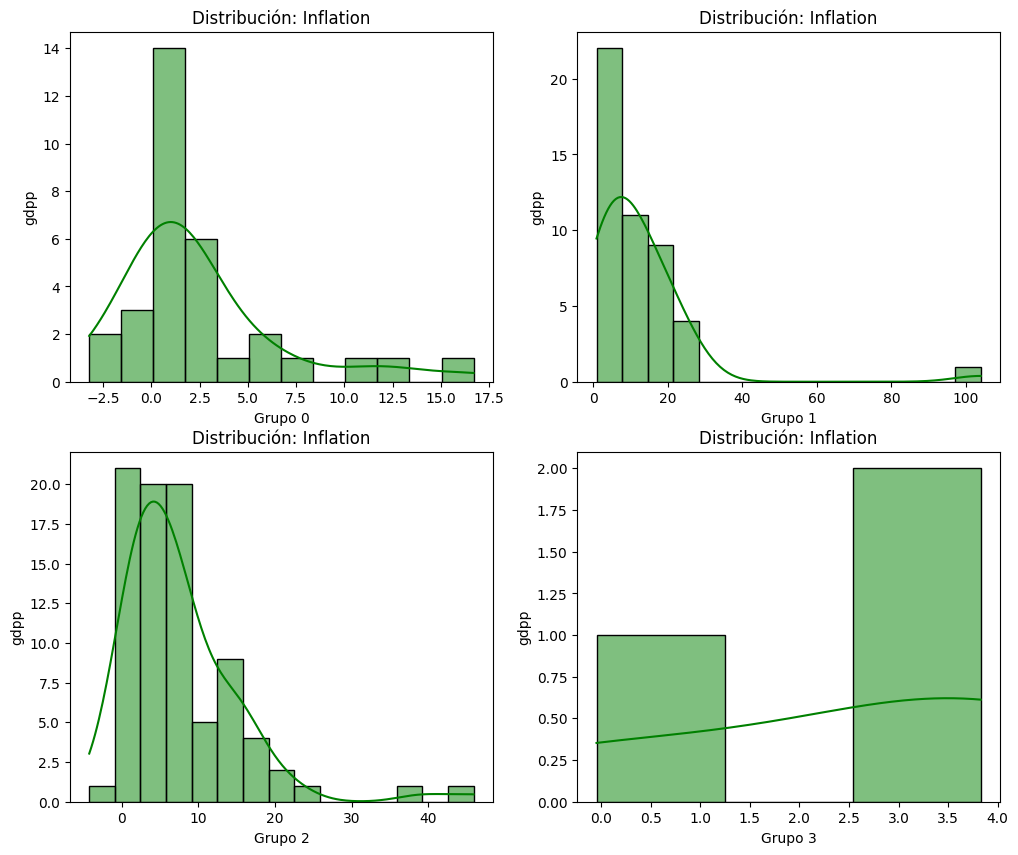

In [ ]:
plt.figure(figsize=(12,10))

# plot distributions for features by group
for i in range(0,4):
  plt.subplot(2,2,i+1)
  sns.histplot(data=df[df['Grupo'] == i], x="inflation", color='green', kde=True)
  plt.title("Distribution: Inflation")
  plt.xlabel('Group {}'.format(i))
  plt.ylabel(col)

We can also visualize what the clusters look like by comparing some of the characteristics.

<Axes: xlabel='income', ylabel='life_expec'>

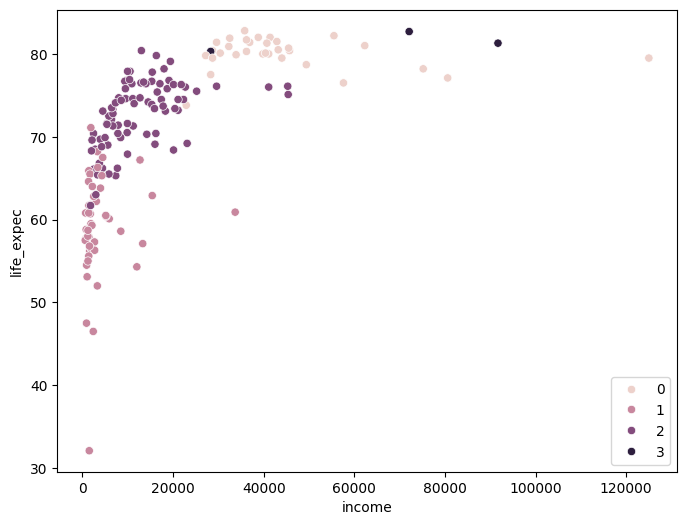

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df,x="income",y="life_expec",hue=label_preds)

<Axes: xlabel='health', ylabel='income'>

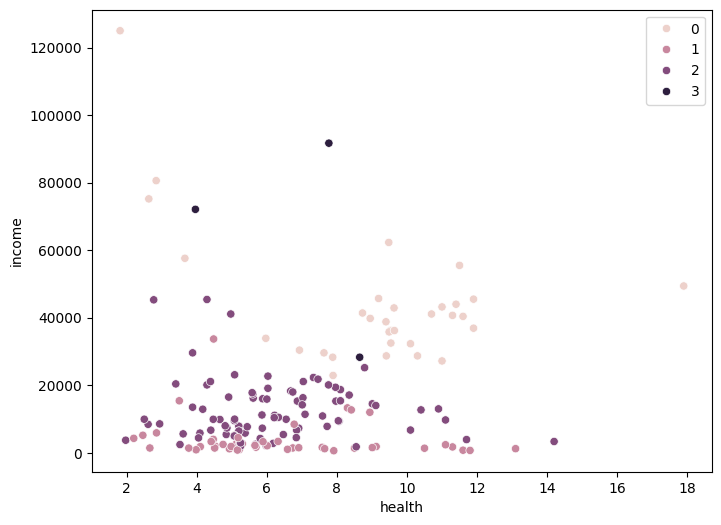

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df,x="health",y="income",hue=label_preds)

To better understand the hierarchical relationships produced by the model, we constructed a dendrogram.

In [ ]:
# build hierarchy array
linkage_matrix = hierarchy.linkage(hier_model.children_)

# pass it to dataframe
linkage_df = pd.DataFrame(linkage_matrix,columns=["Primer Punto","Segundo Punto","Distancia entre Puntos","No. de Puntos en el Cluster"])
linkage_df.head()

,Primer Punto,Segundo Punto,Distancia entre Puntos,No. de Puntos en el Cluster
0,10.0,36.0,1.414214,2.0
1,136.0,143.0,1.414214,2.0
2,150.0,156.0,2.236068,2.0
3,158.0,160.0,2.236068,2.0
4,159.0,169.0,2.236068,3.0


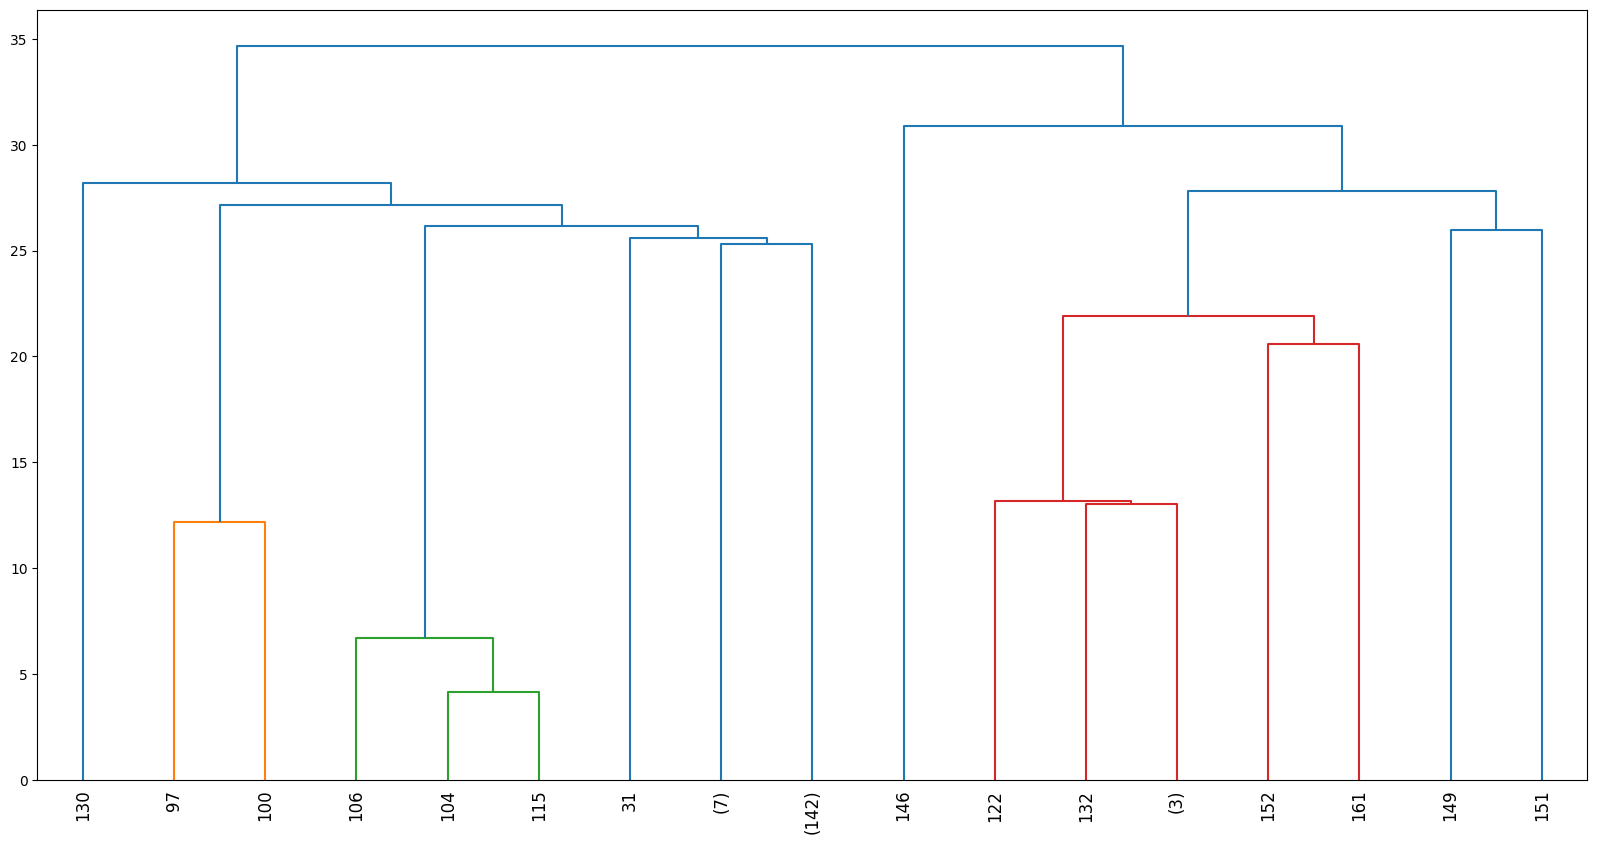

In [ ]:
# display dendrogram
plt.figure(figsize=(20,10))
dendrogram = hierarchy.dendrogram(linkage_matrix,truncate_mode="level", p=5)
plt.xticks(rotation=90)
plt.grid(False)
plt.show()

In [ ]:
df['country'].iloc[104], df['country'].iloc[115], df['country'].iloc[106]

('Montenegro', 'Oman', 'Mozambique')

## Clustering: DBSCAN

Most unsupervised methods for clustering are based on the calculation of distances to find the points with the greatest similarities and group them into clusters. Another approach is to calculate the distance between values ​​and give the algorithm some guidance on what is the minimum acceptable distance to belong to a cluster. This approach (Density-based spatial clustering) is based on the idea that clusters are contiguous regions of high density, separated from other clusters by regions of low density.


Unlike K-Means, this DBSCAN does not need a specification regarding the number of clusters to form.


*Image taken from Towards Data Science*

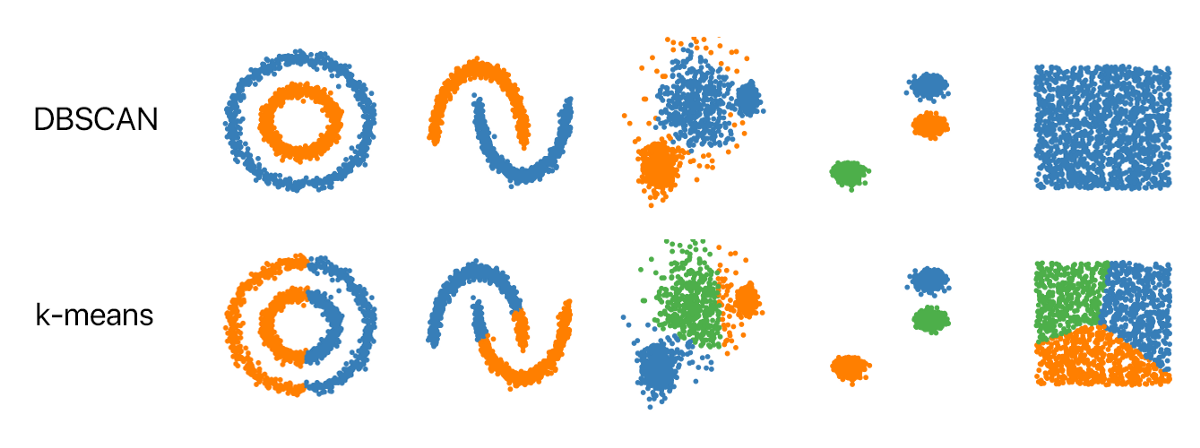

DBSCAN has two parameters:

* eps: distance to locate points in the neighborhood of any point.

* minPts: minimum number of points grouped in a region to be considered dense.

In [ ]:
# initialize model
db_model = DBSCAN(eps=2)

# train model
db_model.fit(data_scaled)

# get predictions
label_preds = db_model.labels_
clusters = list(set(label_preds))
print('Clusters: ', set(clusters))
label_preds

Clusters:  {0, -1}


array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,
        0,  0, -1, -1,  0,  0, -1,  0,  0,  0,  0,  0,  0, -1,  0,  0, -1,
        0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,
        0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0, -1,  0,  0,  0, -1,  0,  0,  0])

In [ ]:
df['Grupo'] = label_preds + 1
df.head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Grupo
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.440,56.2,5.82,553,1
1,Albania,16.6,28.0,6.55,48.6,9930,4.490,76.3,1.65,4090,1
2,Algeria,27.3,38.4,4.17,31.4,12900,16.100,76.5,2.89,4460,1
3,Angola,119.0,62.3,2.85,42.9,5900,22.400,60.1,6.16,3530,1
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.440,76.8,2.13,12200,1
5,Argentina,14.5,18.9,8.10,16.0,18700,20.900,75.8,2.37,10300,1
6,Armenia,18.1,20.8,4.40,45.3,6700,7.770,73.3,1.69,3220,1
7,Australia,4.8,19.8,8.73,20.9,41400,1.160,82.0,1.93,51900,1
8,Austria,4.3,51.3,11.00,47.8,43200,0.873,80.5,1.44,46900,1
9,Azerbaijan,39.2,54.3,5.88,20.7,16000,13.800,69.1,1.92,5840,1


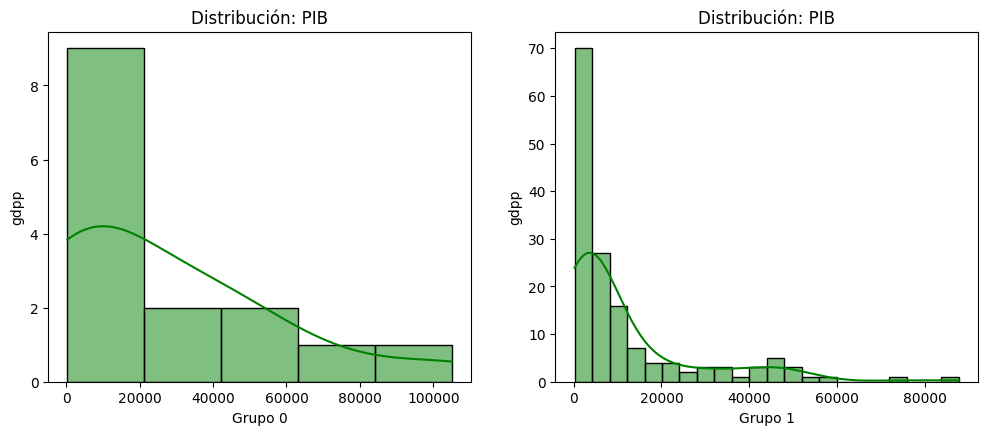

In [ ]:
plt.figure(figsize=(12,10))

# plot distributions for features by group
for i, k in enumerate(clusters):
  plt.subplot(2,2,i+1)
  sns.histplot(data=df[df['Grupo'] == i], x="gdpp", color='green', kde=True)
  plt.title("Distribution: GDPP")
  plt.xlabel('Group {}'.format(i))
  plt.ylabel(col)

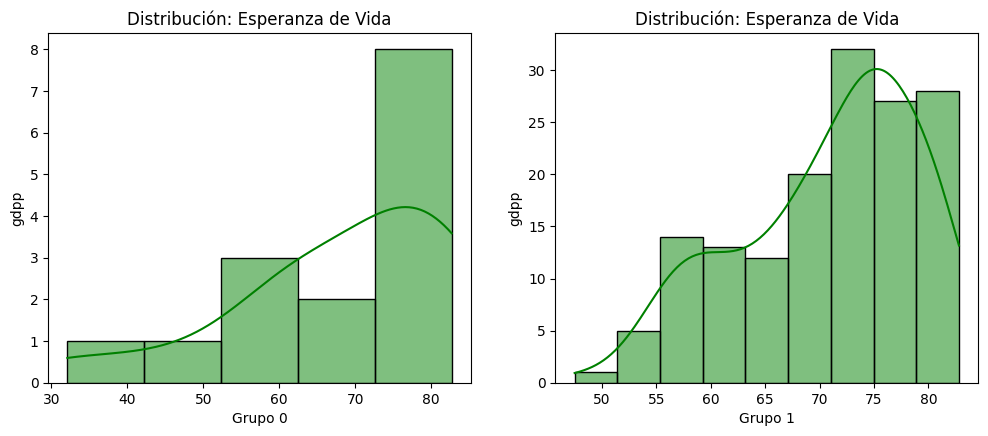

In [ ]:
plt.figure(figsize=(12,10))

# plot distributions for features by group
for i, k in enumerate(clusters):
  plt.subplot(2,2,i+1)
  sns.histplot(data=df[df['Grupo'] == i], x="life_expec", color='green', kde=True)
  plt.title("Distribution: Life Expectancy")
  plt.xlabel('Group {}'.format(i))
  plt.ylabel(col)

<Axes: xlabel='life_expec', ylabel='income'>

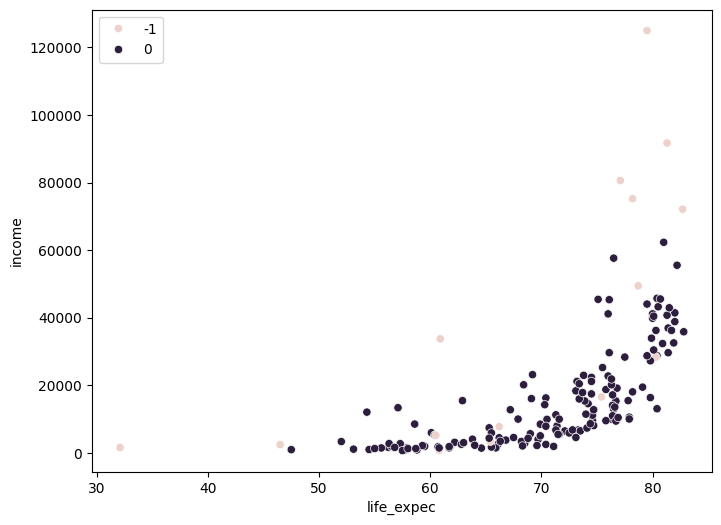

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df,x="life_expec",y="income",hue=label_preds)

<Axes: xlabel='gdpp', ylabel='child_mort'>

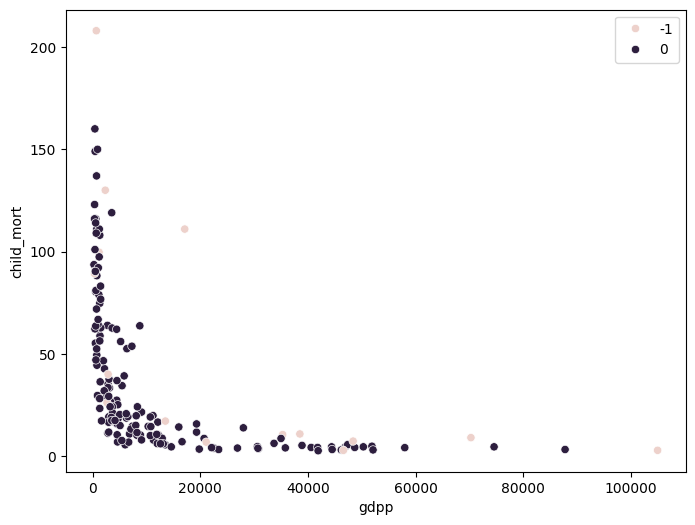

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df,x="gdpp",y="child_mort",hue=label_preds)

In order to find the optimal value of eps, we can perform a search on the parameter space.

In [ ]:
outlier_percent = []

for eps in np.linspace(0.001,3,50):

    # train model
    db_model = DBSCAN(eps=eps, min_samples=2*data_scaled.shape[1])
    db_model.fit(data_scaled)

    # get percentage of outliers
    perc_outliers = 100 * np.sum(db_model.labels_ == -1) / len(db_model.labels_)

    outlier_percent.append(perc_outliers)

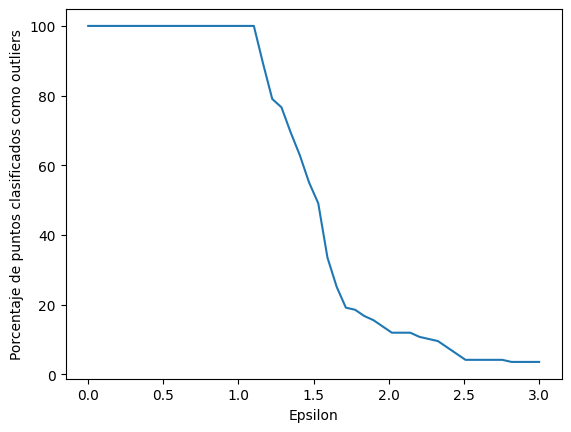

In [ ]:
sns.lineplot(x=np.linspace(0.001,3,50),y=outlier_percent)
plt.ylabel("Percentage of points classified as outliers")
plt.xlabel("Epsilon")
plt.show()

We can observe from the graph that the minimum outliers are obtained approximately for a value of eps=2.5. Therefore, we take this value and retrain the model to have the final clusters.

In [ ]:
# initialize model
db_model = DBSCAN(eps=2.5, min_samples=2*data_scaled.shape[1])

# train model
db_model.fit(data_scaled)

# get predictions
label_preds = db_model.labels_
clusters = list(set(label_preds))

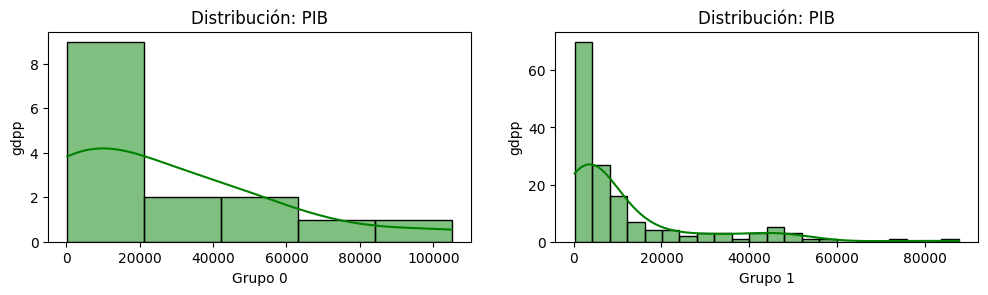

In [ ]:
plt.figure(figsize=(12,6))

# plot distributions for features by group
for i, k in enumerate([0,1]):
  plt.subplot(2,2,i+1)
  sns.histplot(data=df[df['Grupo'] == k], x="gdpp", color='green', kde=True)
  plt.title("Distribution: GDPP")
  plt.xlabel('Group {}'.format(i))
  plt.ylabel(col)

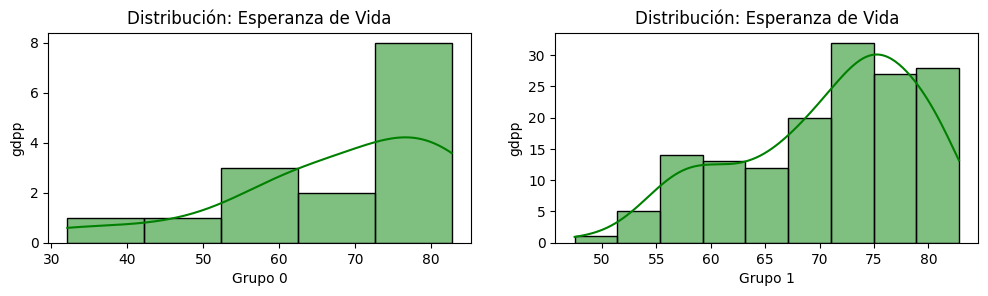

In [ ]:
plt.figure(figsize=(12,6))

# plot distributions for features by group
for i, k in enumerate([0,1]):
  plt.subplot(2,2,i+1)
  sns.histplot(data=df[df['Grupo'] == k], x="life_expec", color='green', kde=True)
  plt.title("Distribution: Life Expectancy")
  plt.xlabel('Group {}'.format(i))
  plt.ylabel(col)

<Axes: xlabel='life_expec', ylabel='income'>

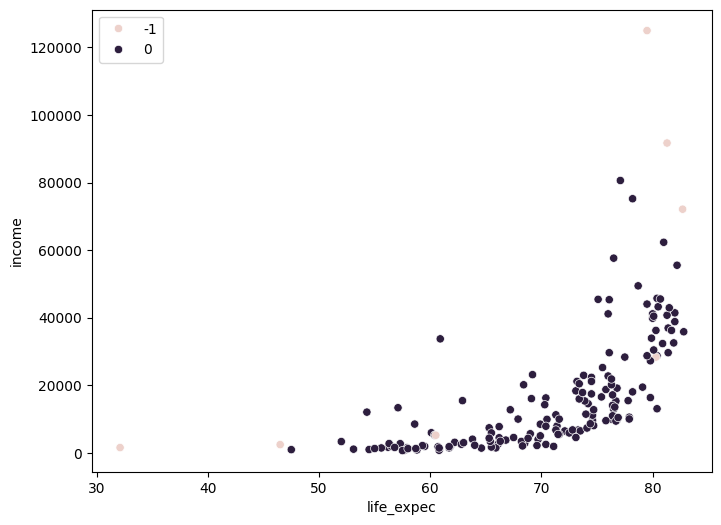

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df,x="life_expec",y="income",hue=label_preds)

<Axes: xlabel='income', ylabel='child_mort'>

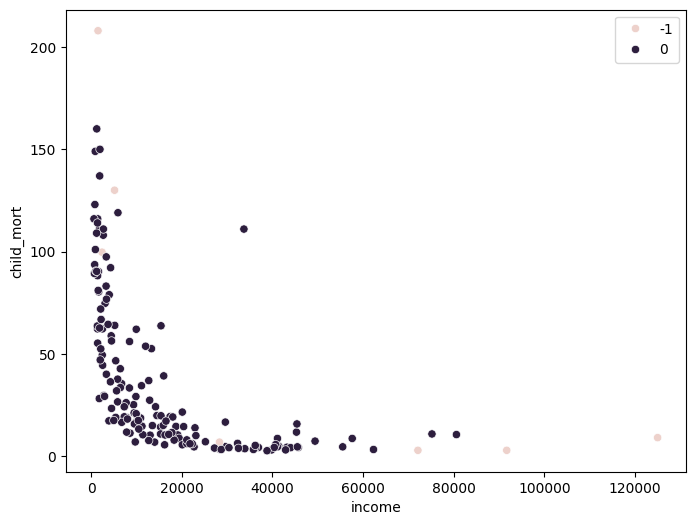

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df,x="income",y="child_mort",hue=label_preds)

DBCAN does not give very consistent results, but it is normal due to the distribution of the data.